* We want to investigate how representations obtained from different layers of Bert can contribute to Homogenization in content recommenders.
* To do this we analyze the average cosine similarity between topic independant keywords and topic specific keywords that are indicative of a particular stance (ie either conservative or liberal)
* If the average cosine similarity of a particular layer is very high then it is an indication that the representations obtained from this layer can contribute to the homogenization effect in content recommenders
    * if topic specific and topic independant word representations have high cosine similarity based on which layer the representations were obtained from then it can indicate that:
        * When the recommendation system is trained on a specific topic and learns the user's preference for this by assigning large weights for keywords/dims that are indicative of the stance that the user prefers for the current topic, when a new topic arrives and the user's preference for this topic is not the same as the previous topic the system was trained on then the large weights can force the classifier to recommend items that are of different partisan stance to whhat the user prefers for this topic but is similar to the stance the user prefers on the original topic the system was first trained on.

In [20]:
%config Completer.use_jedi = False

In [21]:
import torch
import pickle
from transformers import BertModel, BertTokenizer
from general_utils import timer
import os
import numpy as np
from bert_utils import load_model, load_tokenizer, batch_text_gen
import torch
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = False

In [23]:
def load_txt(filename):
    """
    """
    word_list = []
    with open(filename,'r') as rp:
        word_list = rp.readlines()
    
    word_list = list(set([w.strip() for w in word_list]))
    print("Loaded file : %s" %filename)
    print("Num Keywords : %s" %str(len(word_list)))
    
    return word_list

def tokenize_bert_single_token(token_batch,tokenizer,debug_flag=False):
    """
    """
    encoded_batch = []
    for token in token_batch:
        encoded_token = tokenizer.encode(token,add_special_tokens=False,padding="max_length",max_length=10) # padding is longest because subwords exist in the vocab so the tokenizer splits a given word into subwords
        if debug_flag:
            print(token)
            print(tokenizer.convert_ids_to_tokens(encoded_token))
        encoded_batch.append(encoded_token)
    
    tokenized_batch = torch.LongTensor(encoded_batch)
    tokenized_tensor = tokenized_batch.to('cuda')
    return tokenized_tensor, encoded_batch


def combine_subwords(hidden_state,token_ids):
    """
    hidden_state_shape = (maxlength_padding,768)
    
    choose token_ids that are not 0
    
    """
    subword_arrs = []
    for t_i,t in enumerate(token_ids):
        if t != 0:
            subword_arrs.append(hidden_state[t_i,:])
    
    return np.mean(subword_arrs,axis=0).reshape(1,-1)

def get_kw_bert_rep(kw_list,layer_map,bert_tokenizer,bert_model,bs=10):
    """
    """
    batch_count = 0
    for kw_batch in batch_text_gen(kw_list,batch_size = bs):
        print("Batch No : %s" %str(batch_count))
        tokenized_kw_batch, encoded_batch_ids = tokenize_bert_single_token(kw_batch,bert_tokenizer)
        batch_out = bert_model(input_ids=tokenized_kw_batch)
        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 
        
        for layer_ind in range(13):
            for t_id, token in enumerate(kw_batch):
                token_hidden_state = batch_hidden_states[layer_ind][t_id,:,:].cpu().detach().numpy()
                # index here to drop the pad tokens and only consider the actual word representation (if subwords then avg the subwords to get word representation) (PAD has token id of 0)
                token_hidden_state = combine_subwords(token_hidden_state,encoded_batch_ids[t_id])
                layer_map[token]["layer_%s"%str(layer_ind)] = token_hidden_state
        batch_count+=1     

def get_batch_size(kw_list,ratio=10):
    """
    """
    batch_size = int(len(kw_list)/ratio)
    
    if len(kw_list) <=25:
        batch_size = len(kw_list)
    
    return batch_size

def compare_bert_rep_token(kw_topic_specific,kw_topic_indep,plot=True):
    """
    """
    bert_mod = load_model()
    bert_tok = load_tokenizer()
    
    bert_map = defaultdict(lambda :defaultdict())
    
    # topic specific keywords
    print("Getting bert representation for Topic Specific Keywords ... \n")
    batch_size = get_batch_size(kw_topic_specific)
    
    get_kw_bert_rep(kw_list=kw_topic_specific,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # topic indep keywords
    print("Getting bert representation for Topic Independent Keywords ... \n")
    batch_size = get_batch_size(kw_topic_indep)
    
    get_kw_bert_rep(kw_list=kw_topic_indep,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # cosin_sim
    cosine_sims_layer_map = defaultdict(list)
    pair_count=0
    for wp in itertools.product(kw_topic_indep,kw_topic_specific):
        for layer_id in range(13):
            cos_sim = cosine_similarity(bert_map[wp[0]]["layer_%s"%str(layer_id)],bert_map[wp[1]]["layer_%s"%str(layer_id)])
            cosine_sims_layer_map[layer_id].append(cos_sim)
        pair_count+=1
    
    print("No of Pairs : %s" %str(pair_count))
    
    # avg
    avg_scores = []
    for layer in sorted(cosine_sims_layer_map.keys()):
        avg_scores.append(np.mean(cosine_sims_layer_map[layer]))
    
    # plot
    if plot:
        fig,ax = plt.subplots(1,1,figsize=(10,8))
        ax.scatter(range(13),avg_scores,s=100)
        ax.set_xlabel("Bert Layers")
        ax.set_ylabel("Avg Cosine Similarity")
        ax.set_xticks(range(-1,13,1))
        ax.set_xlim(-1,13)
        ax.set_ylim(0.0,1.0)
        sns.regplot(x=[i for i in range(13)], y=avg_scores,ax=ax,color="cornflowerblue")
        plt.title("Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.show()
    return bert_map,avg_scores

In [24]:
# conservative keyword paths
conserv_topic_indep_kw_path = "Files/Keyword_Lists/Topic_Independant_keywords_Conservative.txt"
conserv_topic_spec_kw_path = "Files/Keyword_Lists/Topic_Specific_keywords_conservative.txt"
# liberal keyword paths
liberal_topic_indep_kw_path = "Files/Keyword_Lists/Topic_independant_keywords_liberals.txt"
liberal_topic_spec_kw_path = "Files/Keyword_Lists/Topic_Specific_keywords_liberal.txt"

In [25]:
conserv_topic_indep_kw = load_txt(conserv_topic_indep_kw_path)
conserv_topic_spec_kw = load_txt(conserv_topic_spec_kw_path)
liberal_topic_indep_kw = load_txt(liberal_topic_indep_kw_path)
liberal_topic_spec_kw = load_txt(liberal_topic_spec_kw_path)

Loaded file : Files/Keyword_Lists/Topic_Independant_keywords_Conservative.txt
Num Keywords : 18
Loaded file : Files/Keyword_Lists/Topic_Specific_keywords_conservative.txt
Num Keywords : 184
Loaded file : Files/Keyword_Lists/Topic_independant_keywords_liberals.txt
Num Keywords : 21
Loaded file : Files/Keyword_Lists/Topic_Specific_keywords_liberal.txt
Num Keywords : 180


In [26]:
print(set(conserv_topic_indep_kw).intersection(liberal_topic_indep_kw))
print(set(conserv_topic_indep_kw).intersection(conserv_topic_spec_kw))
print(set(liberal_topic_indep_kw).intersection(liberal_topic_spec_kw))
print(set(conserv_topic_spec_kw).intersection(liberal_topic_spec_kw))

set()
set()
set()
{'mandates', 'grueling', 'impede', 'regulator', 'pardons', 'propelled', 'pessimistic', 'betrayal', 'trooper', 'socialite', 'capitalize', 'impoverished', 'christians', 'morality', 'severity', 'punishments', 'positioning', 'penalty', 'impeachable', 'expectancy', 'supremacy', 'crackdown', 'capitalist', 'extremists', 'estranged', 'unfit', 'retaliate', 'implication'}


## Conservative Keywords Comparison

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Batch No : 10
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
No of Pairs : 3312


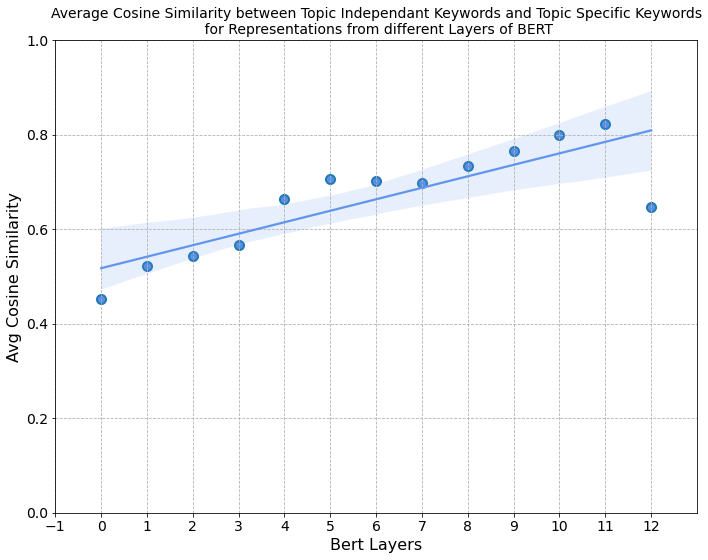

In [27]:
layer_map,avg_scores_cons = compare_bert_rep_token(kw_topic_specific=conserv_topic_spec_kw,
                                   kw_topic_indep=conserv_topic_indep_kw)

## Liberal Keywords Comparison

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
No of Pairs : 3780


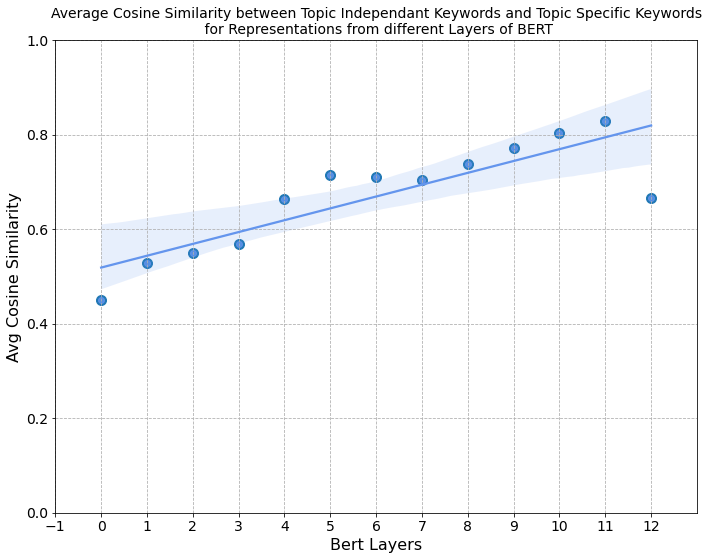

In [28]:
layer_map,avg_scores_lib = compare_bert_rep_token(kw_topic_specific=liberal_topic_spec_kw,
                                   kw_topic_indep=liberal_topic_indep_kw)

## Checking if cosine similarity between words are just higher for some layers

### Using cosine similarity between topic specific conservative keywords and topic specific liberal keywords

In [29]:
conserv_topic_spec_kw = list(set(conserv_topic_spec_kw) - set(liberal_topic_spec_kw))

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Batch No : 10
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
No of Pairs : 28080


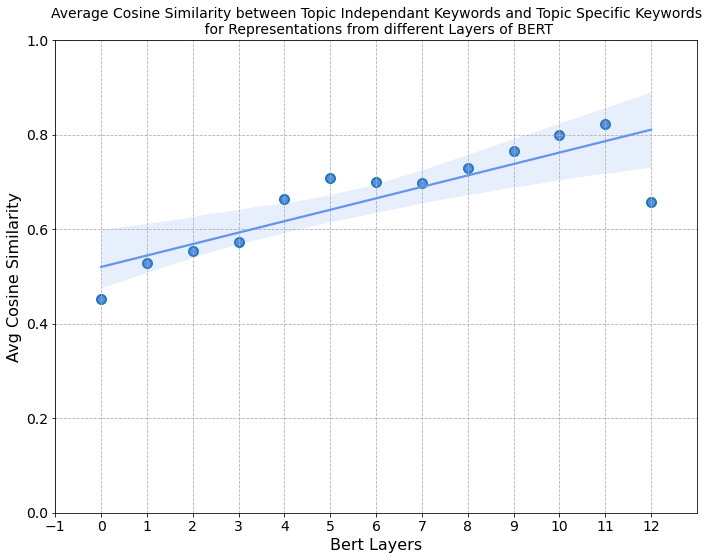

In [30]:
layer_map,avg_scores_cons_lib = compare_bert_rep_token(kw_topic_specific=conserv_topic_spec_kw,
                                   kw_topic_indep=liberal_topic_spec_kw)

### Using cosine similarity between random words

In [31]:
from urllib.request import Request, urlopen
import random


url="https://svnweb.freebsd.org/csrg/share/dict/words?revision=61569&view=co"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

web_byte = urlopen(req).read()

webpage = web_byte.decode('utf-8')
words = webpage.split("\n")
print(len(words))

25488


In [32]:
rl1 = [random.choice(words).strip() for i in range(100)]
rl2 = [random.choice(words).strip() for i in range(100)]

In [33]:
print(set(rl1).intersection(rl2))

{'literacy'}


Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
No of Pairs : 10000


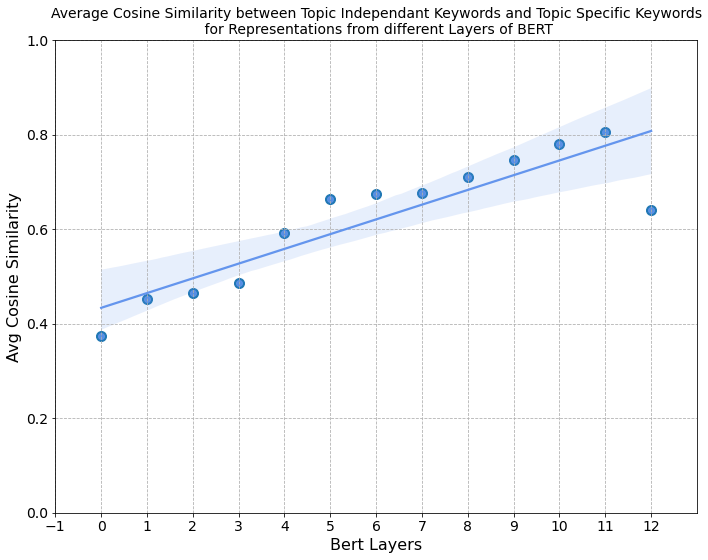

In [34]:
layer_map,avg_scores_rp = compare_bert_rep_token(kw_topic_specific=rl1,
                                   kw_topic_indep=rl2)

### Normalized Correction for cosine similarity between topic specific and topic independant keywords

In [35]:
normalized_cosine_avg_cons = np.array(avg_scores_cons)/np.array(avg_scores_rp)
normalized_cosine_avg_libs = np.array(avg_scores_lib)/np.array(avg_scores_rp)

print(normalized_cosine_avg_cons)
print(avg_scores_cons)
print(avg_scores_rp)

[1.2106304 1.1560991 1.1705413 1.1681074 1.1204782 1.0623932 1.0388811
 1.0316937 1.0301806 1.0267205 1.0240251 1.021128  1.0086149]
[0.4525036, 0.522111, 0.54417855, 0.56726545, 0.66362125, 0.7064499, 0.70121694, 0.6980361, 0.7329407, 0.76659167, 0.7998896, 0.8229656, 0.6470789]
[0.37377515, 0.4516144, 0.46489477, 0.48562783, 0.59226614, 0.66496086, 0.67497325, 0.67659235, 0.71146816, 0.74664104, 0.78112304, 0.8059377, 0.641552]


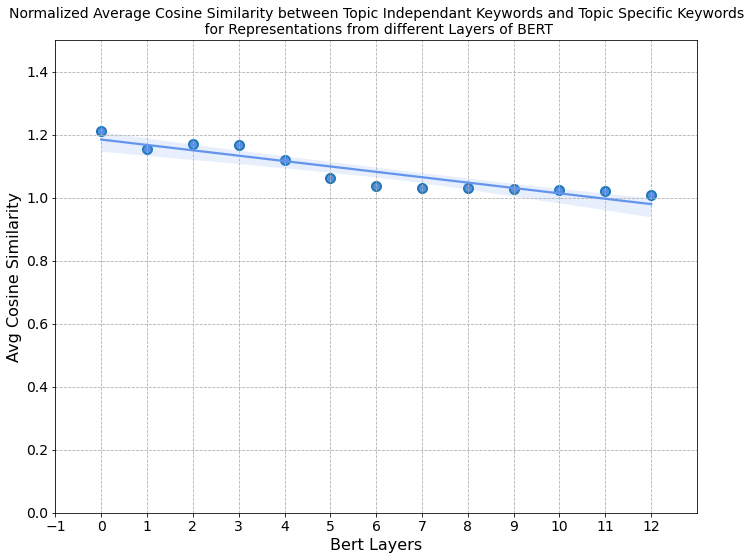

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.scatter(range(13),normalized_cosine_avg_cons,s=100)
ax.set_xlabel("Bert Layers")
ax.set_ylabel("Avg Cosine Similarity")
ax.set_xticks(range(-1,13,1))
ax.set_xlim(-1,13)
ax.set_ylim(0.0,1.5)
sns.regplot(x=[i for i in range(13)], y=normalized_cosine_avg_cons,ax=ax,color="cornflowerblue")
plt.title("Normalized Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

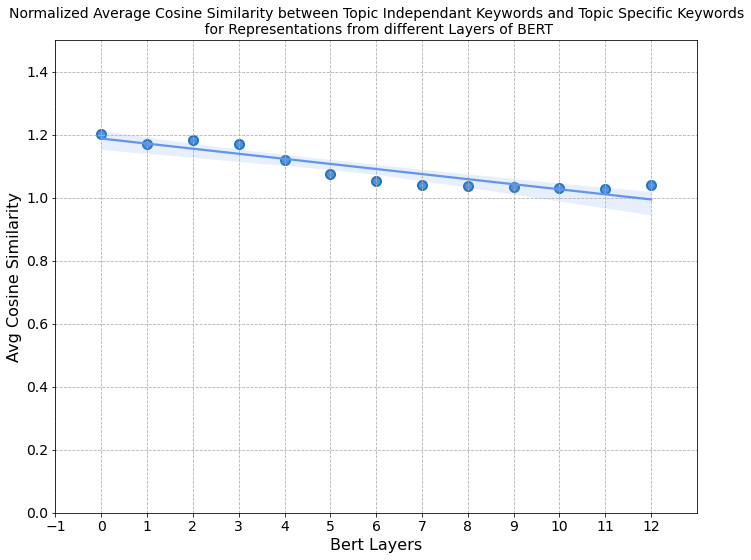

In [37]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.scatter(range(13),normalized_cosine_avg_libs,s=100)
ax.set_xlabel("Bert Layers")
ax.set_ylabel("Avg Cosine Similarity")
ax.set_xticks(range(-1,13,1))
ax.set_xlim(-1,13)
ax.set_ylim(0.0,1.5)
sns.regplot(x=[i for i in range(13)], y=normalized_cosine_avg_libs,ax=ax,color="cornflowerblue")
plt.title("Normalized Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

## Using Representations by feeding in Articles so the representations are highly context dependant

In [24]:
from general_utils import timer

from config import RANDOM_SEED

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from collections import Counter, defaultdict

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [ ]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)

reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [ ]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)

In [ ]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=400,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))

In [ ]:
def get_all_related_docs(cluster_pairs,sample_df,doc_2_cluster_map):
    """
    """
    all_cluster1, all_cluster2 = zip(*cluster_pairs)
    
    all_clusters = list(set(all_cluster1 + all_cluster2)) 
    
    related_docs = []
    
    for clus in all_clusters:
        doc_ids = doc_2_cluster_map[clus]
        related_docs += [sample_df["processed_text"].iloc[did] for did in doc_ids]
    
    print("Number of documents that were clustered after filtering : %s" %str(len(related_docs)))
    
    return related_docs

In [ ]:
related_docs = get_all_related_docs(filtered_cluster_pairs,sampled_df,doc_2_cluster_map)

In [ ]:
def get_kw_bert_rep(doc_list,layer_map,bert_tokenizer,bert_model,bs=10):
    """
    """
    batch_count = 0
    for kw_batch in batch_text_gen(kw_list,batch_size = bs):
        print("Batch No : %s" %str(batch_count))
        tokenized_kw_batch, encoded_batch_ids = tokenize_bert_single_token(kw_batch,bert_tokenizer)
        batch_out = bert_model(input_ids=tokenized_kw_batch)
        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 
        
        for layer_ind in range(13):
            for t_id, token in enumerate(kw_batch):
                token_hidden_state = batch_hidden_states[layer_ind][t_id,:,:].cpu().detach().numpy()
                # index here to drop the pad tokens and only consider the actual word representation (if subwords then avg the subwords to get word representation) (PAD has token id of 0)
                token_hidden_state = combine_subwords(token_hidden_state,encoded_batch_ids[t_id])
                layer_map[token]["layer_%s"%str(layer_ind)] = token_hidden_state
        batch_count+=1   

def get_kw_rep_using_articles(article_list,token,token_index_map,bert_tokenizer,bert_model):
    """
    """
    for article in article_list:
        tokenized_tensor = torch.LongTensor(tokenizer.encode(article,
                                                          truncation=True,
                                                          padding="max_length",
                                                          max_length=500))
        tokenized_tensor = tokenized_tensor.to('cuda')
        out = bert_model(input_ids=tokenized_tensor)
        hidden_states = batch_out[2]
        
        for layer_ind in range(13):
            # i need the tokens rep from all layers
                   